In [1]:
# Import tensorflow for the CNN and limit the memory usage
import tensorflow as tf
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="1" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

2021-10-05 16:21:14.875866: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-05 16:21:15.008170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:5b:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-10-05 16:21:15.008979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:9e:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2021-10-05 16:21:15.009322: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-05 16:21:15.012365: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10

In [2]:
# Load necessary libraries
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from botorch.models.transforms.outcome import Standardize

import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Parameters setup
device = "cpu"  # for now, set device to CPU as the number of samples are small.
dtype = torch.double
NOISE_SE = 0.0
niter = 50
nrep = 1
option_standardize = True

In [4]:
# Function that loads the saved weights in CNN.

# input:
# path: hdf5 file that saves the weights of a VGG16 network.

# output:
# model: Keras model with VGG16 architecture and the loaded weights.
from keras import applications
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

def loadCNNmodel(path):
    model = applications.VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
    print('Model loaded')
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.0))
    top_model.add(Dense(1,activation=None))
    new_model = Sequential()

    for l in model.layers:
        new_model.add(l)

    new_model.add(top_model)
    new_model.load_weights(path)
    print('CNN model loaded with weights.')
    return new_model

Using TensorFlow backend.


In [5]:
# model using the whole FOV
model_path = '/home/chenyu/Desktop/CNNmeasurement/CoarseCNNtraining/VGG16/OptimalPar_newData/Test6_Normalize_HighCs_emitxdefocus/Attempt_10_emit+defocus_Adam/Final_model_2.h5'
# refine model using 30 mrad aperture
model_path_finetune = '/home/chenyu/Desktop/CNNmeasurement/CoarseCNNtraining/VGG16/OptimalPar_newData/Test12_Normalize_Cs_3fold_C5_negC1_WhiteNoise_Aperture/Attempt_01_emit+defocus_dropout_0.1_30mrad/Final_model.h5'

model = loadCNNmodel(model_path)
model_finetune = loadCNNmodel(model_path_finetune)

2021-10-05 16:21:16.159941: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-10-05 16:21:16.186527: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2200000000 Hz
2021-10-05 16:21:16.190616: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f02d0000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-05 16:21:16.190656: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-05 16:21:16.434592: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555d54dc8fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-10-05 16:21:16.434640: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2021-10-05 16:21:16.434652: I tensorflow

Model loaded
CNN model loaded with weights.
Model loaded
CNN model loaded with weights.


In [6]:
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [7]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [8]:
# the function to get the output from GPT
# input:
# x: coordinate in the parameter space to be observed, 1-by-6 numpy array with each number between [0,1].
# model: Keras model that saves the CNN model to quantify the beam quality from GPT output.

# output:
# y: single number from CNN output, higher stands for better beam quality.
import sys
sys.path.insert(1, '/home/chenyu/Desktop/git/STEMalign/GPT_misalignment/')
from uscope import sim

def get_GPT_output(x, model, aperture):
    x_list = []
    x_low = np.asarray([1000, -40, 387000, -685000, -3.7515e6, 119000, 640000])
    x_high = np.asarray([2800, 40, 393000, -622500, -3.7495e6, 120300, 651000])
    xlim, ylim, shadow = sim(             
         S1CV  = 0.0,
         S1CH  = 0.0,
         S2CV  = 0.0,
         S2CH  = 0.0,
         S3CV  = 0.0,
         S3CH  = 0.0,
         H1CV  = (x[6] - 0.5) * 1e-7,
         H1CH  = (x[7] - 0.5) * 1e-7,
         S4CV  = 0.0,
         S4CH  = 0.0,
         S5CV  = 0.0,
         S5CH  = 0.0,
         H2CV  = (x[8] - 0.5) * 1e-7,
         H2CH  = (x[9] - 0.5) * 1e-7,
         S6CV  = 0.0,
         S6CH  = 0.0,
         S7CV  = 0.0,
         S7CH  = 0.0,
         ObjCH = 0.0,
         ObjCV = 0.0,
         alpha = 1.0e-4*5,
         S1 = 2.5e5,
         S2 = 2.5e5,
         H1 = x[0] * (x_high[0] - x_low[0]) + x_low[0],
         H2 = x[0] * (x_high[0] - x_low[0]) + x_low[0] + x[1] * (x_high[1] - x_low[1]) + x_low[1],
         S3 = x[4]* (x_high[5] - x_low[5]) + x_low[5],  # 119931.5,
         S4 = x[5]* (x_high[6] - x_low[6]) + x_low[6],  # 648691.415,
         S6 = x[2]* (x_high[2] - x_low[2]) + x_low[2],  # 390000,
         S7 = x[3]* (x_high[3] - x_low[3]) + x_low[3],  # -654100.0
         Obj = -3.7505e6,
    )
    frame = scale_range(shadow, 0, 1)
    if aperture:
        frame = frame * aperture_generator(128, 40, 30)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
    x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
    prediction = model.predict(x_list, batch_size = 1)
    # print(prediction)
    return shadow, 1 - prediction[0][0]

/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
2021-10-05 16:21:35.664978: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-05 16:21:35.870958: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


0.9092090278863907


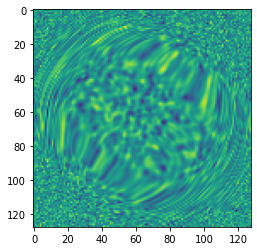

In [9]:
# test with arbitrary input x
# x = np.array([0,0,0,0,0,0])
x = np.array([ 0.2768, 0.5056, 0.5, 0.4944, 0.7165, 0.7901, 0.5, 0.5, 0.5, 0.5])
# x = np.array([0.5449, 0.1241, 0.7564, 0.5801, 0.4578, 0.9086])
ronch, output = get_GPT_output(x, model_finetune, 0)
print(output)
plt.imshow(ronch)

In [10]:
# Function that generate n random data point with noise.

# input:
# n: number of datapoints to gerate
def generate_initial_data(n, model, aperture):
    # generate training data
    train_x = torch.rand(n, 10, device=device, dtype=dtype)
    output_y = [get_GPT_output(np.array(train_x[i,:]), model, aperture)[1] for i in range(n)]
    train_y = torch.tensor(output_y).unsqueeze(-1)
    train_y = train_y + NOISE_SE * torch.randn_like(train_y) if NOISE_SE else train_y
    best_observed_value = train_x.max().item()
    return train_x, train_y

In [ ]:
# initial optimization without applying aperture
best_seen_rep = []
best_par_rep = []
best_ronchigram_rep = []
best_seen_ronchigram = np.zeros([128, 128])

if option_standardize:
    outcome_transformer = Standardize( m = 1,
    batch_shape = torch.Size([]),
    min_stdv = 1e-08)

for irep in range(nrep):
    
    train_X, train_Y = generate_initial_data(n = 10, model = model, aperture = 0)
    
    if option_standardize:
        gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
    else:
        gp = SingleTaskGP(train_X, train_Y)
        
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    bounds = torch.stack([torch.zeros(10, device = device), torch.ones(10, device = device)])
    best_observed_value = []
    
    for iteration in range(niter):

        fit_gpytorch_model(mll)

        UCB = UpperConfidenceBound(gp, beta = 2)    
        candidate, acq_value = optimize_acqf(
            UCB, bounds=bounds, q = 1, num_restarts=5, raw_samples=20,
        )
        new_x = candidate.detach()
        print(new_x)
        
        result = get_GPT_output(np.array(new_x[0]), model, 0)
        new_y = torch.tensor(result[1]).unsqueeze(-1).unsqueeze(-1)
        new_y = new_y + NOISE_SE * torch.randn_like(new_y)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        if not best_observed_value:
            best_par = np.array(new_x[0])
            best_value = np.array(new_y[0][0])
            best_seen_ronchigram = result[0]
        elif result[1] > best_value:
            best_par = np.array(new_x[0])
            best_value = result[1]
            best_seen_ronchigram = result[0]
        best_observed_value.append(best_value)

        # update GP model using dataset with new datapoint
        if option_standardize:
            gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
        else:
            gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

        print(iteration, best_value)
        
    best_seen_rep.append(np.array(best_observed_value))
    best_par_rep.append(best_par)
    best_ronchigram_rep.append(best_seen_ronchigram)
    
# np.save('Initial_optimization_std_50iter_50reps_value.npy', np.array(best_seen_rep))
# np.save('Initial_optimization_std_50iter_50reps_ronchigrams.npy', np.array(best_ronchigram_rep))
# np.save('Initial_optimization_std_50iter_50reps_parameters.npy', np.array(best_par_rep))

In [ ]:
plt.imshow(best_seen_ronchigram)
print(result[1])
print(result[0].shape)

In [ ]:
best_par_rep = np.load('Initial_optimization_50iter_50reps_parameters.npy')

In [ ]:
# Case to start with previous saved results
best_ronchigram_rep_refine = np.load('Refine_optimization_std_50iter_50reps_ronchigrams.npy')
best_seen_rep_refine = np.load('Refine_optimization_std_50iter_50reps_value.npy')
best_par_rep_refine = np.load('Refine_optimization_std_50iter_50reps_parameters.npy')

best_par_rep_refine = [best_par_rep_refine[i] for i in range(len(best_par_rep_refine))]
best_seen_rep_refine = [best_seen_rep_refine[i] for i in range(len(best_seen_rep_refine))]
best_ronchigram_rep_refine = [best_ronchigram_rep_refine[i] for i in range(len(best_ronchigram_rep_refine))]

In [ ]:
# refine with aperture applied
# best_par_rep_refine = []
# best_seen_rep_refine = []
# best_ronchigram_rep_refine = []

for irep in range(len(best_par_rep_refine), len(best_par_rep)):
    
    print('Now working on '+ str(irep) + ' ' + str(best_par_rep[irep]))
    
    # randomly generate 9 training data points, plus the one with best seen values
    train_X, train_Y = generate_initial_data(n = 9, model = model_finetune, aperture = 30)
    
    # add in the best seen point from previous optimization
    new_x = best_par_rep[irep]
    result = get_GPT_output(new_x, model_finetune, 30)
    new_x = torch.tensor([new_x])
    new_y = torch.tensor(result[1]).unsqueeze(-1).unsqueeze(-1)
    new_y = new_y + NOISE_SE * torch.randn_like(new_y) if NOISE_SE else new_y
    train_X = torch.cat([train_X, new_x])
    train_Y = torch.cat([train_Y, new_y])
    
    # build GP model from the ten training points
    if option_standardize:
        gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
    else:
        gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    bounds = torch.stack([torch.zeros(10, device = device), torch.ones(6, device = device)])
    best_observed_value = []
    
    for iteration in range(niter):

        fit_gpytorch_model(mll)

        UCB = UpperConfidenceBound(gp, beta = 2)    
        candidate, acq_value = optimize_acqf(
            UCB, bounds=bounds, q = 1, num_restarts=5, raw_samples=20,
        )
        new_x = candidate.detach()
#         print(new_x)
        
        result = get_GPT_output(np.array(new_x[0]), model_finetune, 30)
        new_y = torch.tensor(result[1]).unsqueeze(-1).unsqueeze(-1)
        new_y = new_y + NOISE_SE * torch.randn_like(new_y)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        if not best_observed_value:
            best_par = np.array(new_x[0])
            best_value = np.array(new_y[0][0])
            best_seen_ronchigram = result[0]
        elif result[1] > best_value:
            best_par = np.array(new_x[0])
            best_value = result[1]
            best_seen_ronchigram = result[0]
        best_observed_value.append(best_value)

        # update GP model using dataset with new datapoint
        if option_standardize:
            gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
        else:
            gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

    
    print(irep, best_value)
        
    best_seen_rep_refine.append(np.array(best_observed_value))
    best_par_rep_refine.append(best_par)
    best_ronchigram_rep_refine.append(best_seen_ronchigram)
    
np.save('Refine_optimization_std_50iter_50reps_value.npy', np.array(best_seen_rep_refine))
np.save('Refine_optimization_std_50iter_50reps_ronchigrams.npy', np.array(best_ronchigram_rep_refine))
np.save('Refine_optimization_std_50iter_50reps_parameters.npy', np.array(best_par_rep_refine))

In [ ]:
temp = np.load('Refine_optimization_50iter_50reps_value.npy', allow_pickle = True)

In [ ]:
np.save('Refine_optimization_50iter_50reps_value.npy', np.array(best_seen_rep_refine))
np.save('Refine_optimization_50iter_50reps_ronchigrams.npy', np.array(best_ronchigram_rep_refine))
np.save('Refine_optimization_50iter_50reps_parameters.npy', np.array(best_par_rep_refine))

In [ ]:
gp.likelihood.noise

In [ ]:
best_ronchigram_rep_refine = np.load('Refine_optimization_50iter_50reps_ronchigrams.npy')
best_seen_rep_refine = np.load('Refine_optimization_50iter_50reps_value.npy')
best_par_rep_refine = np.load('Refine_optimization_50iter_50reps_parameters.npy')

In [ ]:
idx = 4
plt.imshow(best_ronchigram_rep_refine[idx])
print(best_seen_rep_refine[idx][-1])

## Plot results

In [ ]:
temp = np.load('Refine_optimization_50iter_50reps_value.npy')
len(temp)

In [ ]:
result = np.load(result_path + 'RandomStartx30_50iter_initialrun_emit+defocus_prmean=0_rltBoundary_2-None.npy')
result.shape

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = [14, 5])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Initial_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax[0].plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'Initial Optimization')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax[0].plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C0', alpha = 0.3)
ax[0].legend(loc='upper left', ncol=1, fontsize = 16)
ax[0].set_xlabel('Iterations',fontsize = 16)
ax[0].set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

result = np.load('Refine_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax[1].plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, c = 'C1', label = 'Refine Optimization')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax[1].plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C1', alpha = 0.3)
ax[1].legend(loc='upper left', ncol=1, fontsize = 16)
ax[1].set_xlabel('Iterations',fontsize = 16)
ax[1].set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

In [ ]:
fig, ax = plt.subplots( figsize = [6, 6])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Initial_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'BoTorch')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C0', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

result = np.load(result_path + 'RandomStartx30_50iter_initialrun_emit+defocus_prmean=0_rltBoundary_2-None.npy')
result = result[:,:50,0]
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'SLAC GP')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C1', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

result = np.load(result_path + 'Simplex_Y-obs-fullGPT_30rep.npy', allow_pickle = True)
result = [np.array(entry)[0:50,0] for entry in result]
result = np.array(result)
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, c = 'C2', label = 'Simplex')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C2', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_yscale('log')

In [ ]:
result = np.load(result_path + 'Simplex_Y-obs-fullGPT_30rep.npy', allow_pickle = True)
result = [np.array(entry)[0:50,0] for entry in result]
result = np.array(result)

In [ ]:
np.array(result).shape